In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [2]:
cd /content/drive/MyDrive/hate_speech/models

/content/drive/MyDrive/hate_speech/models


In [3]:
! pip install transformers==4.25.1

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 60.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 182.4/182.4 KB 19.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 86.5 MB/s eta 0:00:00


In [4]:
import torch.nn as nn
from transformers import DistilBertForSequenceClassification,BertForSequenceClassification, BertTokenizer, AdamW, get_linear_schedule_with_warmup
import pandas as pd
import torch
from torch.utils.data import TensorDataset, random_split, DataLoader, RandomSampler, SequentialSampler
import time
import pickle
from tqdm import tqdm
import matplotlib.pyplot as plt
import random
import numpy as np
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix, classification_report
import torch
from transformers import TrainingArguments, Trainer
from transformers import BertTokenizer, BertForSequenceClassification
from transformers import EarlyStoppingCallback
     

In [5]:
# Define pretrained tokenizer and model
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)
model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=3)

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/483 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_layer_norm.weight', 'vocab_transform.weight', 'vocab_transform.bias', 'vocab_projector.weight', 'vocab_layer_norm.bias', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.weight', 'pre_classifier.bias', 'classifier

In [ ]:
train_csv = pd.read_csv('../data/Davidson/train.csv', names=['label','tweet'],header=0)
dev_csv = pd.read_csv('../data/Davidson/dev.csv', names=['label','tweet'], header=0)
X_train = tokenizer(list(train_csv["tweet"]), padding=True, truncation=True, max_length=300)
X_dev = tokenizer(list(dev_csv["tweet"]), padding=True, truncation=True, max_length=300)
y_train = list(train_csv["label"])
y_dev = list(dev_csv["label"])

In [7]:
# Create torch dataset
class Dataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels, device=DEVICE):
        self.encodings = encodings
        self.labels = labels
        self.device = device

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]).to(self.device) for key, val in self.encodings.items()}
        item["labels"] = torch.tensor(self.labels[idx]).to(self.device)
        return item

    def __len__(self):
        return len(self.encodings["input_ids"])


In [ ]:
train_dataset = Dataset(X_train, y_train)
dev_dataset = Dataset(X_dev, y_dev)

In [ ]:
# Define Trainer parameters
def compute_metrics(p):
    pred, labels = p
    pred = np.argmax(pred, axis=1)

    accuracy = accuracy_score(y_true=labels, y_pred=pred)
    recall = recall_score(y_true=labels, y_pred=pred, average = "weighted")
    precision = precision_score(y_true=labels, y_pred=pred, average = "weighted")
    f1 = f1_score(y_true=labels, y_pred=pred, average = "weighted")

    return {"accuracy": accuracy, "precision": precision, "recall": recall, "f1": f1}

In [ ]:
# Define Trainer
args = TrainingArguments(
    output_dir="output",
    evaluation_strategy="steps",
    eval_steps=500,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=2,
    seed=1234,
    load_best_model_at_end=True,
    dataloader_pin_memory=False
)
trainer = Trainer(
    model=model,
    args=args,
    train_dataset=train_dataset,
    eval_dataset=dev_dataset,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=5)],
)

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


In [ ]:
# Train pre-trained model
trainer.train()

***** Running training *****
  Num examples = 19826
  Num Epochs = 2
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 4958
  Number of trainable parameters = 66955779
The following columns in the training set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: token_type_ids. If token_type_ids are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.


Step,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
500,0.340800,0.297936,0.900726,0.893587,0.900726,0.896302
1000,0.311700,0.278390,0.910815,0.890838,0.910815,0.887501
1500,0.285500,0.305877,0.910815,0.895447,0.910815,0.896859
2000,0.276700,0.308434,0.906780,0.897962,0.906780,0.901140
2500,0.277200,0.308718,0.911622,0.894030,0.911622,0.893986
3000,0.225100,0.292863,0.916061,0.899852,0.916061,0.899199
3500,0.229000,0.325606,0.914447,0.908014,0.914447,0.892670


***** Running Evaluation *****
  Num examples = 2478
  Batch size = 8
The following columns in the evaluation set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: token_type_ids. If token_type_ids are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
Saving model checkpoint to output/checkpoint-500
Configuration saved in output/checkpoint-500/config.json
Model weights saved in output/checkpoint-500/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 2478
  Batch size = 8
The following columns in the evaluation set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: token_type_ids. If token_type_ids are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
Saving model checkpoint to output/checkpoint-1000
Configuration saved in output/checkpoint-1000/config.json
Mod

TrainOutput(global_step=3500, training_loss=0.278000002179827, metrics={'train_runtime': 982.5894, 'train_samples_per_second': 40.355, 'train_steps_per_second': 5.046, 'total_flos': 2172866302796400.0, 'train_loss': 0.278000002179827, 'epoch': 1.41})

In [8]:
# test
test_csv = pd.read_csv('../data/Davidson/test.csv', names=['label','tweet'], header=0)
X_test = tokenizer(list(test_csv["tweet"]), padding=True, truncation=True, max_length=300)
y_test = list(test_csv["label"])

test_dataset = Dataset(X_test, y_test)

In [9]:
# Load trained model
model_path = "output/checkpoint-1000"
trained_model = DistilBertForSequenceClassification.from_pretrained(model_path, num_labels=3)

In [10]:
# Define tester
args = TrainingArguments(
    output_dir="tester",
    dataloader_pin_memory=False
)
tester = Trainer(model=trained_model, args=args)

In [11]:
# Make prediction
raw_pred, _, _ = tester.predict(test_dataset)

***** Running Prediction *****
  Num examples = 2479
  Batch size = 8
The following columns in the test set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: token_type_ids. If token_type_ids are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.


In [12]:
# Preprocess raw predictions
y_pred = np.argmax(raw_pred, axis=1)

In [13]:
def plot_confusion_matrix(y_true, y_pred, classes, normalize=False, title=None, cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    #classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

Confusion matrix, without normalization
[[   5  128   20]
 [   1 1876   49]
 [   0   22  378]]


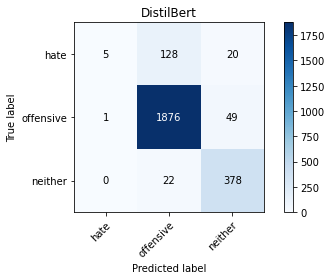

In [14]:
plot_confusion_matrix(y_test, y_pred, classes = ["hate","offensive","neither"], normalize=False, title='DistilBert')

Normalized confusion matrix
[[3.26797386e-02 8.36601307e-01 1.30718954e-01]
 [5.19210800e-04 9.74039460e-01 2.54413292e-02]
 [0.00000000e+00 5.50000000e-02 9.45000000e-01]]


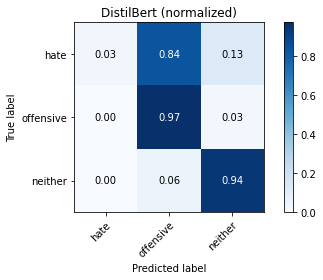

In [15]:
plot_confusion_matrix(y_test, y_pred, classes = ["hate","offensive","neither"], normalize=True, title='DistilBert (normalized)')

In [16]:
print(classification_report(y_test, y_pred, target_names=["hate","offensive","neither"]))

              precision    recall  f1-score   support

        hate       0.83      0.03      0.06       153
   offensive       0.93      0.97      0.95      1926
     neither       0.85      0.94      0.89       400

    accuracy                           0.91      2479
   macro avg       0.87      0.65      0.63      2479
weighted avg       0.91      0.91      0.89      2479

